In [ ]:
!pip install pycuda
!pip install matplotlib

     |████████████████████████████████| 1.6MB 8.2MB/s 
     |████████████████████████████████| 71kB 9.9MB/s 
     |████████████████████████████████| 81kB 9.8MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp36-cp36m-linux_x86_64.whl size=621010 sha256=e0fcf57de9dd1b2d3b89fa2c701ec74459d58f8f3c8e4cba7ce347a9e9cda2f8
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2020.4.3-py2.py3-none-any.whl size=61374 sha256=4bcb33b7ce64786fa235f49d51a334f3f38e3ce173a62b21f214132660e5e5fe
  Stored in directory: /root/.cache/pip/wheels/af/c7/81/a22edb90b0b09a880468b2253bb1df8e9f503337ee15432c64
Successfully built pycuda pytools


In [ ]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy
import time

ARRAY_SIZES = [1000,10000,100000,1000000,10000000,100000000]
BLOCK_SIZE = 512

execution_times = []
for ARRAY_SIZE in ARRAY_SIZES:

  GRID = (ARRAY_SIZE // BLOCK_SIZE if ARRAY_SIZE % BLOCK_SIZE == 0 else ARRAY_SIZE // BLOCK_SIZE + 1)
  
  a = numpy.float32(numpy.random.rand())
  x = numpy.random.randn(ARRAY_SIZE).astype(numpy.float32)
  y = numpy.random.randn(ARRAY_SIZE).astype(numpy.float32)
  result_GPU = numpy.random.randn(ARRAY_SIZE).astype(numpy.float32)

  mod = SourceModule("""
    __global__ void saxpy(float *x, float *y, float a, float *result)
    {
      int idx = blockIdx.x * blockDim.x + threadIdx.x;
      result[idx] = a * x[idx] + y[idx];
    }
    """)

  # Run on GPU with timing
  func = mod.get_function("saxpy")
  time_GPU_pre = time.time()
  func(cuda.In(x), cuda.In(y), a, cuda.Out(result_GPU), block=(BLOCK_SIZE, 1, 1), grid=(GRID, 1))
  time_GPU_post = time.time()
  delta_time_GPU = time_GPU_post - time_GPU_pre

  time_CPU_pre = time.time()
  result_CPU = a * x + y
  time_CPU_post = time.time()
  delta_time_CPU = time_CPU_post - time_CPU_pre

  execution_times.append([delta_time_GPU,delta_time_CPU])

  print(f"GRID: {GRID}")
  if (numpy.allclose(result_CPU, result_GPU, 0.1)):
    print("Results are equal!")
  else:
    print("Results are NOT equal!")

for exec_time in execution_times:
  print(f"GPU time / CPU time: {exec_time[0] / exec_time[1]}")

0.0012731552124023438
GRID: 2
Results are equal!
0.0006554126739501953
GRID: 20
Results are equal!
0.0008630752563476562
GRID: 196
Results are equal!
0.004067182540893555
GRID: 1954
Results are equal!
0.030517578125
GRID: 19532
Results are equal!
0.2655003070831299
GRID: 195313
Results are equal!
GPU time / CPU time: 0.22297381936615307
GPU time / CPU time: 1.2360611510791366
GPU time / CPU time: 1.900262467191601
GPU time / CPU time: 2.1653973089616656
GPU time / CPU time: 1.7771853826502277
GPU time / CPU time: 1.6316274531063646


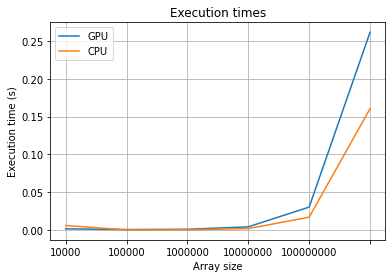

In [ ]:
import matplotlib.pyplot as plt

gpu_plot_data = []
cpu_plot_data = []
for i in range(len(ARRAY_SIZES)):
  gpu_plot_data.append(execution_times[i][0])
  cpu_plot_data.append(execution_times[i][1])

fig, ax = plt.subplots()
ax.plot(gpu_plot_data, label="GPU")
ax.plot(cpu_plot_data, label="CPU")
ax.set_xticklabels(ARRAY_SIZES)

ax.legend()

ax.set(xlabel='Array size', ylabel='Execution time (s)',
       title='Execution times')
ax.grid()

plt.show()